In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from glob import glob
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [9]:
df = pd.read_csv("../datas/AxisData/2025-06-28.csv")
df['Torque6'] = df['Torque6'].apply(eval)

In [23]:
corr.to_excel("../files/corr.xlsx")

Text(0.5, 1.0, '震动与温度相关性热图')

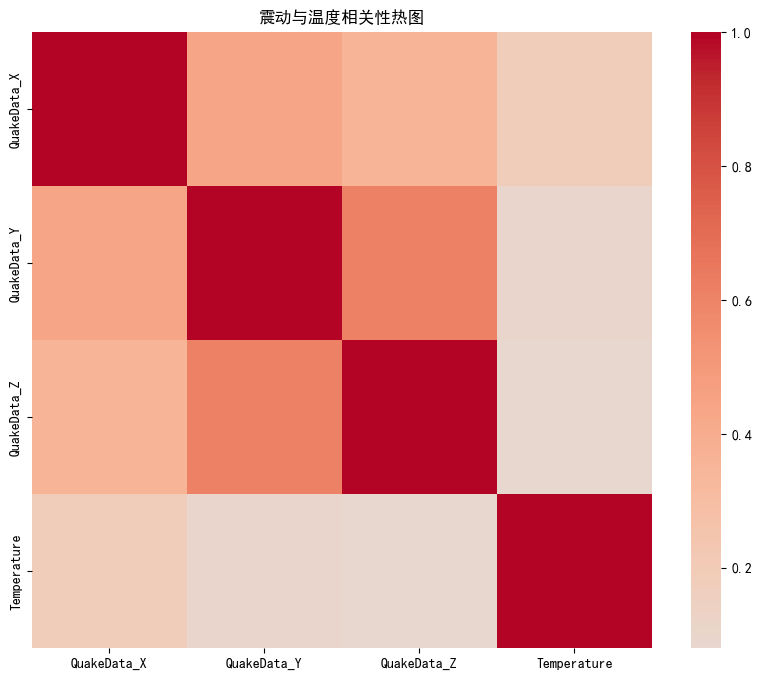

In [19]:
# 轴数据分析
plt.figure(figsize=(10, 8))
corr = df[df.columns[1:5]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, center=0, annot=False, cmap='coolwarm')  #, mask=mask
plt.title('震动与温度相关性热图')

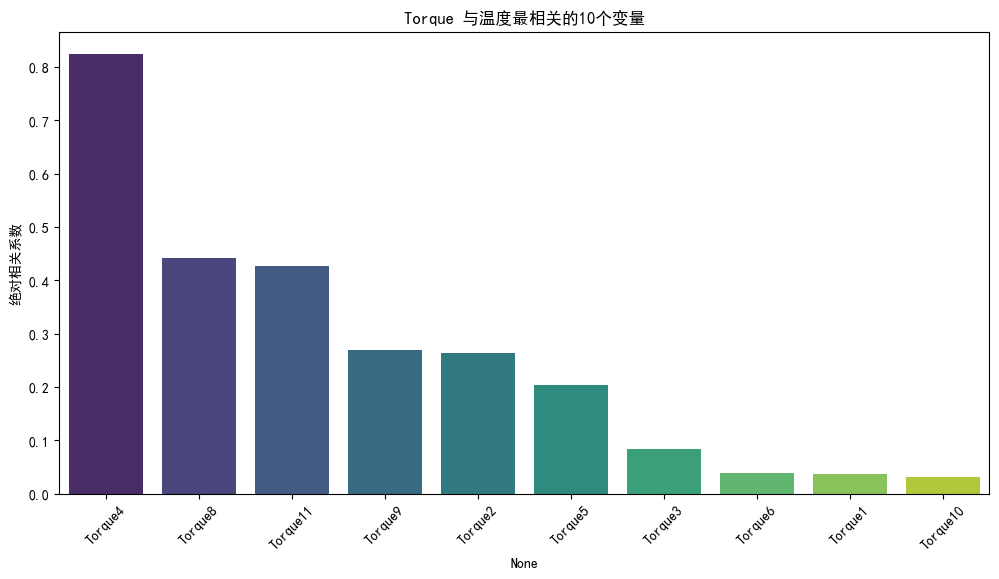

In [31]:
# 假设您的DataFrame名为df
# 首先计算与Temperature列的相关性（Temperature列名需要替换为实际列名）
# 替换'temperature'为您的实际Temperature列名
# temperature_corr = df[df.columns[1:]].corr()[['Temperature']].drop('Temperature', errors='ignore')

axis_cols = [col for col in df.columns if 'Axis' in col]
axis_df = df[['Temperature'] + axis_cols].copy()

# 提取所有WP列
torque_cols = [col for col in df.columns if 'Torque' in col]
torque_df = df[['Temperature'] + torque_cols].copy()

axis_corr = axis_df.corr()[['Temperature']].drop('Temperature', errors='ignore')
torque_corr = torque_df.corr()[['Temperature']].drop('Temperature', errors='ignore')

num = 10
# 计算绝对相关系数并排序
top_correlations = (
    torque_corr
    .assign(abs_corr=lambda x: x['Temperature'].abs())  # 添加绝对值列
    .sort_values('abs_corr', ascending=False)    # 按绝对值降序排序
    .head(num)                                     # 取前6（可能包含自身）
    .drop('abs_corr', axis=1)                   # 删除辅助列
)

# 移除Temperature与自身的相关项（如果存在）
if 'Temperature' in top_correlations.index:
    top_correlations = top_correlations.drop('Temperature', errors='ignore').head(5)

# print(f"与温度相关性最高的{num}个变量（按绝对值排序）:")
# print(top_correlations)

# 可视化前5个相关变量（可选）
plt.figure(figsize=(12, 6))
sns.barplot(x=top_correlations.index, 
            y=top_correlations['Temperature'].abs(),
            palette="viridis")
plt.title(f'Torque 与温度最相关的{num}个变量')
plt.ylabel('绝对相关系数')
plt.xticks(rotation=45)
plt.show()

In [33]:
# top_correlations.to_excel("../files/axis_corr.xlsx", sheet_name="Torque")
# 检查文件是否存在，如果不存在直接写入新文件
file_path = "../files/axis_corr.xlsx"
try:
    with pd.ExcelWriter(file_path, mode='a', engine='openpyxl') as writer:
        # 判断'Torque'工作表是否存在
        if 'Torque' in writer.book.sheetnames:
            # 如果存在则创建新sheet（避免覆盖），这里采用增加序号的方式
            sheet_names = [name for name in writer.book.sheetnames if name.startswith('Torque')]
            new_sheet_name = f"Torque_{len(sheet_names)}"
            top_correlations.to_excel(writer, sheet_name=new_sheet_name)
        else:
            top_correlations.to_excel(writer, sheet_name="Torque")
except FileNotFoundError:
    # 文件不存在时创建新文件
    top_correlations.to_excel(file_path, sheet_name="Torque")